In [1]:
%matplotlib inline
import pandas as pd
from IPython.display import display
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import math
import os
import numpy
import sys

sys.path.append("python/")

from datasets import get_dataset, bruteforce
from distance import jaccard, l2
from lsh import LSHBuilder, LSH
from main import run_single_exp
from metrics import result_prob, total_variation_dist

plt.rcParams["figure.figsize"] =(20,10)
pd.options.display.max_rows = 2000
plt.rcParams['mathtext.fontset'] = 'cm'
#plt.rcParams['font.family'] = 'cmu serif'
plt.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
plt.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
plt.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'


sns.set(rc={'text.usetex' : False})
sns.set_style("whitegrid")


sns.set_context('paper', font_scale=5)

df = pd.read_csv("exp-res/exp.csv").replace({
    "glove-100-angular" : "GLOVE",
    "movielens" : "MovieLens",
    "lastfm" : "LastFM",
    "sift-128-euclidean" : "SIFT",
    "mnist-784-euclidean" : "MNIST",
    "weighted_uniform": "weighted uniform",
    "approx_degree": "approx. degree"
})

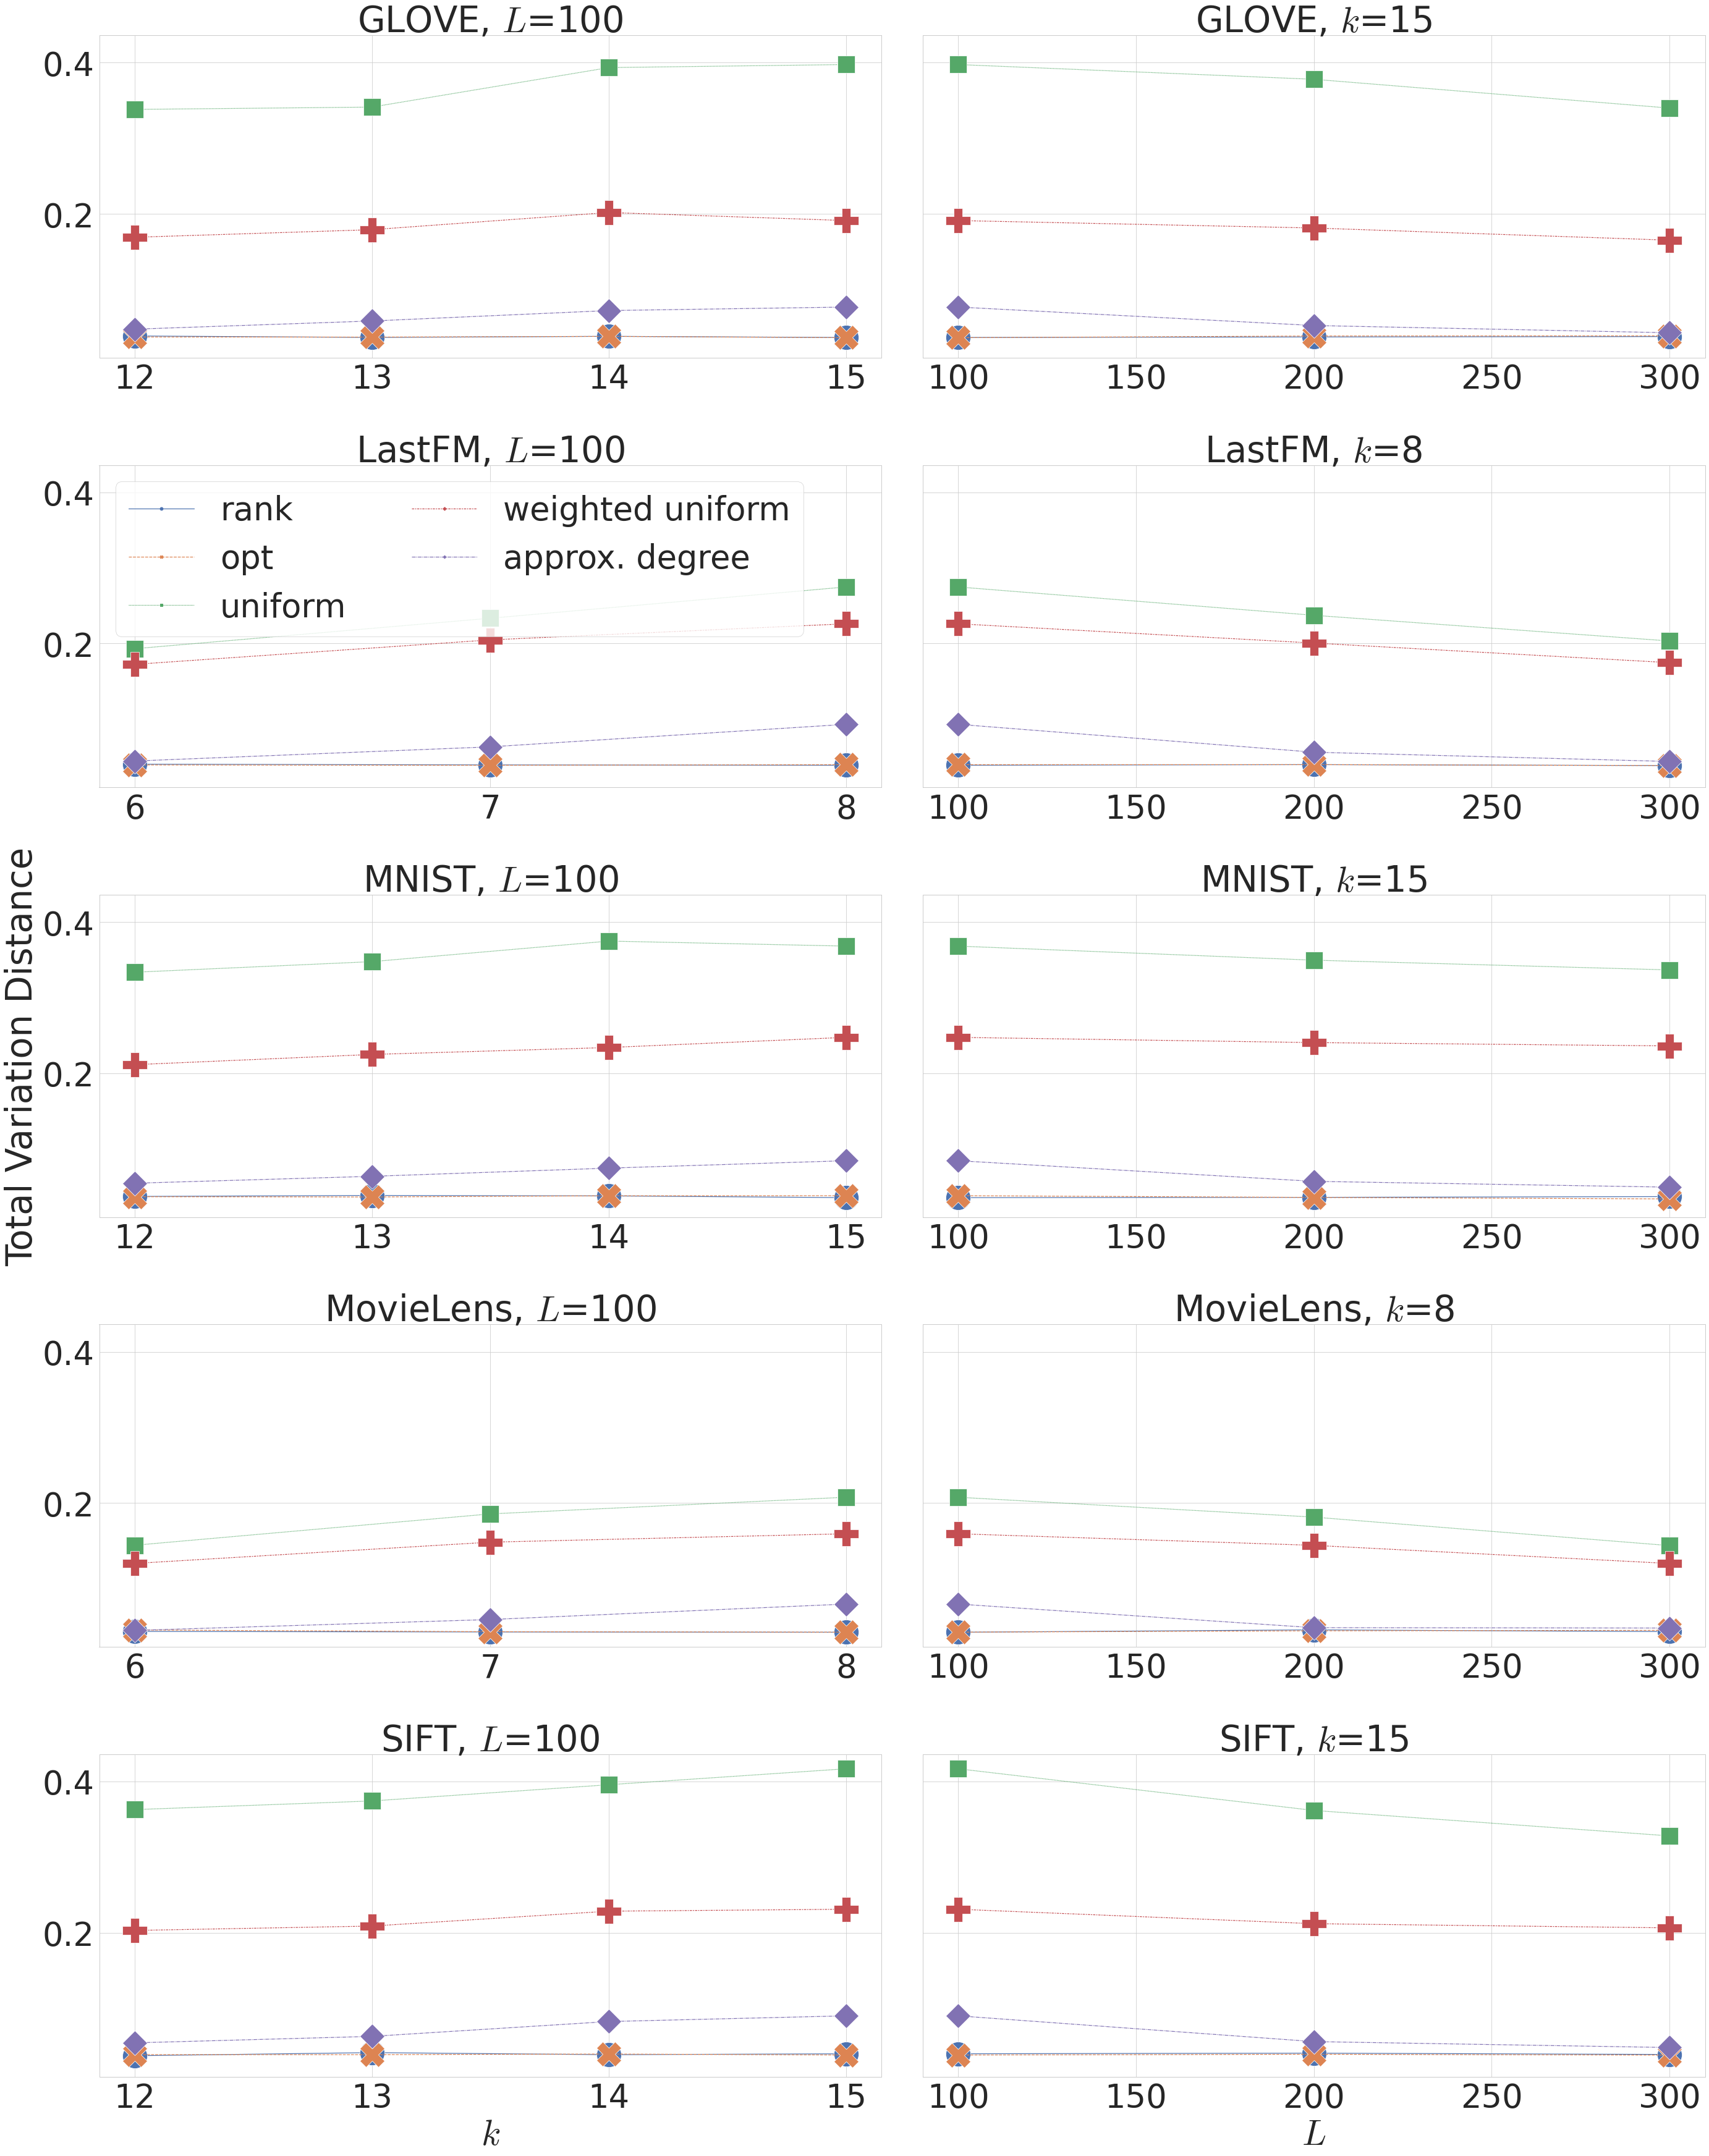

In [5]:
plt.rcParams["figure.figsize"] =(40,50)
sns.set_context('paper', font_scale=6)
fig, axs = plt.subplots(5, 2, sharey=True, sharex=False)
for i, ds in enumerate(sorted(set(df.dataset))):
    for k in set(df[df.dataset==ds].k):
        if len(set(df[(df.dataset==ds) & (df.k == k)].L.values)) > 1:
            #plt.title(f"{ds}, k={k}")
            axs[i,1].set_title(f"{ds}, $k$={k}")
            sns.lineplot(ax=axs[i,1], data=df[(df.k == k) & (df.dataset == ds)], x="L", y="tvd",style="method", hue="method", markers=True, ms=40, legend=False)

for i, ds in enumerate(sorted(set(df.dataset))):
    for L in set(df[df.dataset==ds].L):
        if len(set(df[(df.dataset==ds) & (df.L == L)].k.values)) > 1:
            #plt.title(f"{ds}, k={k}")
            axs[i,0].set_title(f"{ds}, $L$={L}")
            sns.lineplot(ax=axs[i,0], data=df[(df.L == L) & (df.dataset == ds)], x="k", y="tvd",style="method", hue="method", markers=True, ms=40, legend=(i == 1))#legend=(i == 2))
            #axs[i].set_xticklabels(map(int, set(df[(df.dataset==ds) & (df.L == L)].k.values)))
            axs[i,0].xaxis.set_major_locator(MaxNLocator(integer=True))


for ax in axs.flat:
    ax.set(xlabel="", ylabel="")

axs[2,0].set(ylabel='Total Variation Distance')
axs[4,1].set(xlabel='$L$')
axs[4,0].set(xlabel='$k$')

#plt.show()
axs[1,0].legend(ncol=2)
plt.tight_layout()
plt.savefig("plots/tvd.pdf")

# Discussion of b_cr/b_r term on real-world datasets

In [6]:
def ratio_plot(ds_name, distance_fn, rs, cs):
    plt.rcParams["figure.figsize"] =(20,10)
    sns.set_context('paper', font_scale=2.5)
    data, queries, _, _ = get_dataset(ds_name)
    groundtruth = bruteforce(data, queries, distance_fn)

    ball_df = pd.DataFrame(data={'r' : [], 'c' : [], 'br' : [], 'bcr' :[], 'i' : [] })

    for r in rs:
        for c in cs:
            for i in range(len(groundtruth)):
                if distance_fn == l2:
                    b_r = len([1 for p in groundtruth[i] if distance_fn(data[p], queries[i]) <= r])
                    b_cr = len([1 for p in groundtruth[i] if distance_fn(data[p], queries[i]) <= r * c])
                elif distance_fn == jaccard:
                    b_r = len([1 for p in groundtruth[i] if distance_fn(data[p], queries[i]) >= r])
                    b_cr = len([1 for p in groundtruth[i] if distance_fn(data[p], queries[i]) >= r * c])
                ball_df = ball_df.append({'r': r, 'c' : c, 'br': b_r, 'bcr' : b_cr, 'i' : i}, ignore_index=True)
                
                
    ball_grouped_df = ball_df.groupby(['r', 'c']).sum().reset_index()
    ball_grouped_df['rel'] = ball_grouped_df[['br', 'bcr']].apply(lambda x:  x[1] / x[0], axis=1)
    sns.catplot(data=ball_grouped_df[['r', 'c', 'rel']].round(2).rename(columns={'r': '$r$', 'c': '$c$', 'rel' : '$b_{cr} / b_r$'}),x='$c$', y='$b_{cr} / b_r$', kind='bar', col='$r$')
    plt.savefig(f"plots/{ds_name}_ratio_plot.pdf")

downloading http://itu.dk/people/maau/fairnn/datasets/lastfm.pickle -> data/lastfm.pickle...


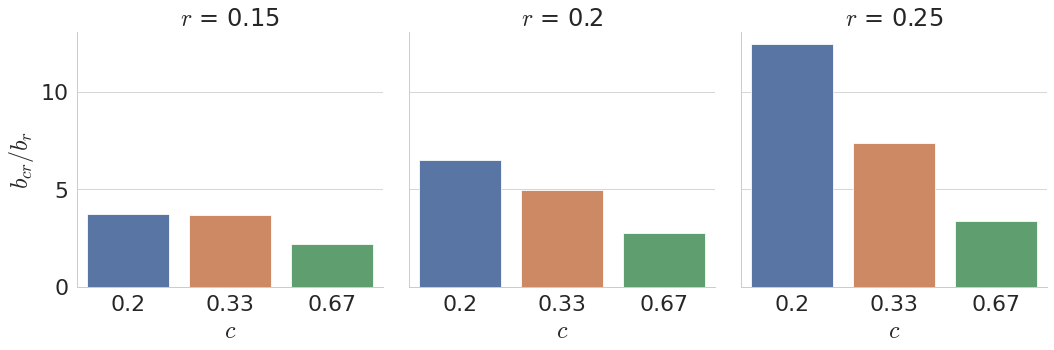

In [7]:
ratio_plot("lastfm", jaccard, (0.15, 0.2, 0.25), (2/3, 1/3, 1/5))

downloading http://itu.dk/people/maau/fairnn/datasets/movielens.pickle -> data/movielens.pickle...


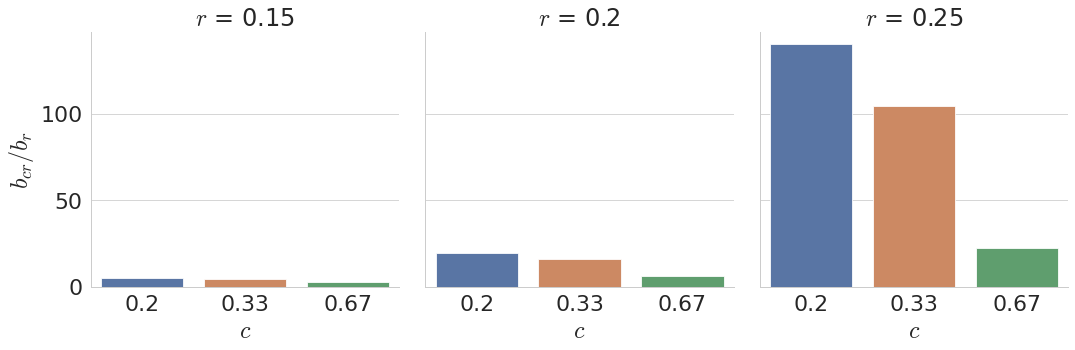

In [8]:
ratio_plot("movielens", jaccard, (0.15, 0.2, 0.25), (2/3, 1/3, 1/5))

downloading http://itu.dk/people/maau/fairnn/datasets/sift-128-euclidean.pickle -> data/sift-128-euclidean.pickle...


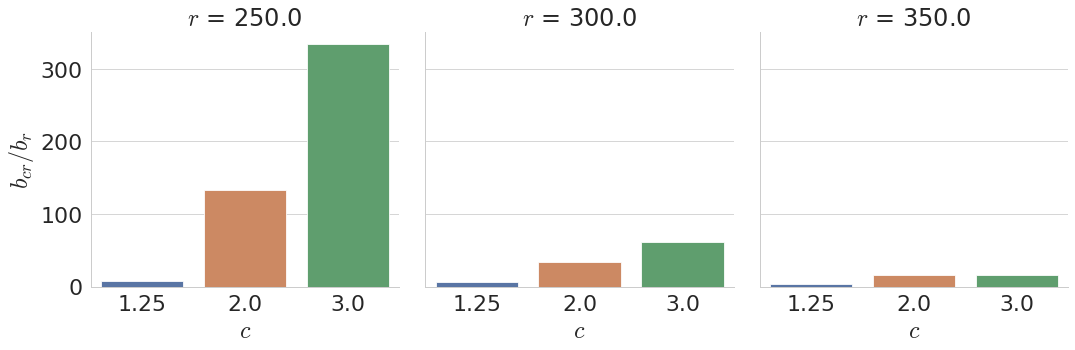

In [9]:
ratio_plot("sift-128-euclidean", l2, (250, 300, 350), (1.25, 2, 3))

downloading http://itu.dk/people/maau/fairnn/datasets/glove-100-angular.pickle -> data/glove-100-angular.pickle...


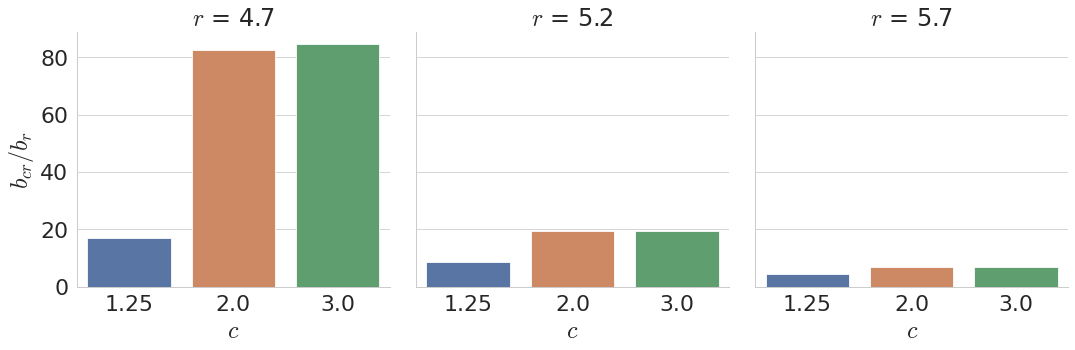

In [10]:
ratio_plot("glove-100-angular", l2, (4.7, 5.2, 5.7), (1.25, 2, 3))

downloading http://itu.dk/people/maau/fairnn/datasets/mnist-784-euclidean.pickle -> data/mnist-784-euclidean.pickle...


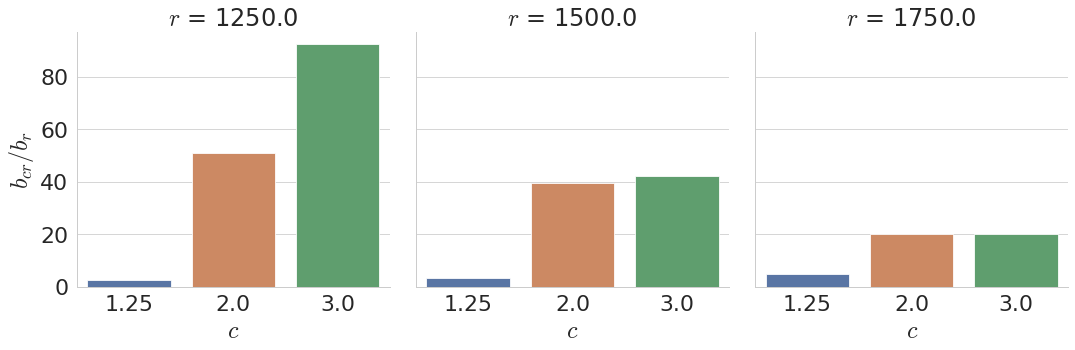

In [11]:
ratio_plot("mnist-784-euclidean", l2, (1250, 1500, 1750), (1.25, 2, 3))

# Fairness of the output

Produce plots that show individual fairness of the output

In [9]:
def produce_distribution_plot(dd, ds, distance_f, r, scale=5):
    import pickle
    plt.rcParams["figure.figsize"] =(20,10)
    sns.set_context('paper', font_scale=3.5)

    df_dict = {
        "query": [],
        "point": [],
        "freq": [],
        "sim": []
    }

    data, queries, _, _ = get_dataset(ds)

    for i, q in enumerate(dd):
        for point, count in dd[q].items():
            df_dict["query"].append(i) 
            df_dict["point"].append(point) 
            df_dict["freq"].append(count) 
            df_dict["sim"].append(distance_f(queries[q], data[point]))
    df = pd.DataFrame(data=df_dict)


    cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)

    if distance_f == l2:
        df = df[df.sim <= r]
    if distance_f == jaccard:
        df = df[df.sim >= r]
    df = df.groupby(['query', 'sim']).mean().reset_index()

    
    norms = df.groupby(['query']).sum().reset_index()[['query', 'freq']]
    norms = norms.rename (columns={'freq' : 'norm'})
    df = df.merge(norms, left_on='query', right_on='query')
    #df['relfreq'] = df[['freq', 'norm']].apply(lambda x: x[0] / x[1], axis=1)
    #max_size = max(df.relfreq.values)
    ax = sns.scatterplot(data=df[df.freq < 0].rename(
                columns={'query' : 'Query', 
                        #'relfreq' : 'rel freq', 
                        'freq' : 'freq', 
                        'sim' : 'Similarity'}), 
                x='Similarity', y = 'Query', 
                hue='freq',
                size='freq', 
                sizes = (50 * scale, 50 * scale),
                palette=sns.color_palette("dark:salmon_r", as_cmap=True)


                )   

    sns.scatterplot(ax=ax, data=df[df.freq >= 0].rename(
                columns={'query' : 'Query', 
                        #'relfreq' : 'rel freq', 
                        'freq' : 'freq', 
                        'sim' : 'Similarity'}), 
                x='Similarity', y = 'Query', 
                hue='freq',
                size='freq', 
                sizes = (60 * scale, 500 * scale),
                palette=cmap
                )   
    
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

    leg = plt.legend()
    for t in leg.texts:
    # truncate label text to 4 characters
        t.set_text(t.get_text()[:4])
    #print(df)
    plt.savefig("plots/lastfm_detail.pdf")
    
    

In [10]:
def get_interesting_queries(res, ):
    query_prob = 1/numpy.array(res["candidates"])
    _, details = total_variation_dist(query_prob, result_prob(res["res"]))
    queries = list(enumerate(details))
    queries.sort(key=lambda x:-x[1])
    return [i for i, q in queries[:5]]

avg. sim (biased): 0.1547820205989762
avg. sim (debiased): 0.26981508840266144


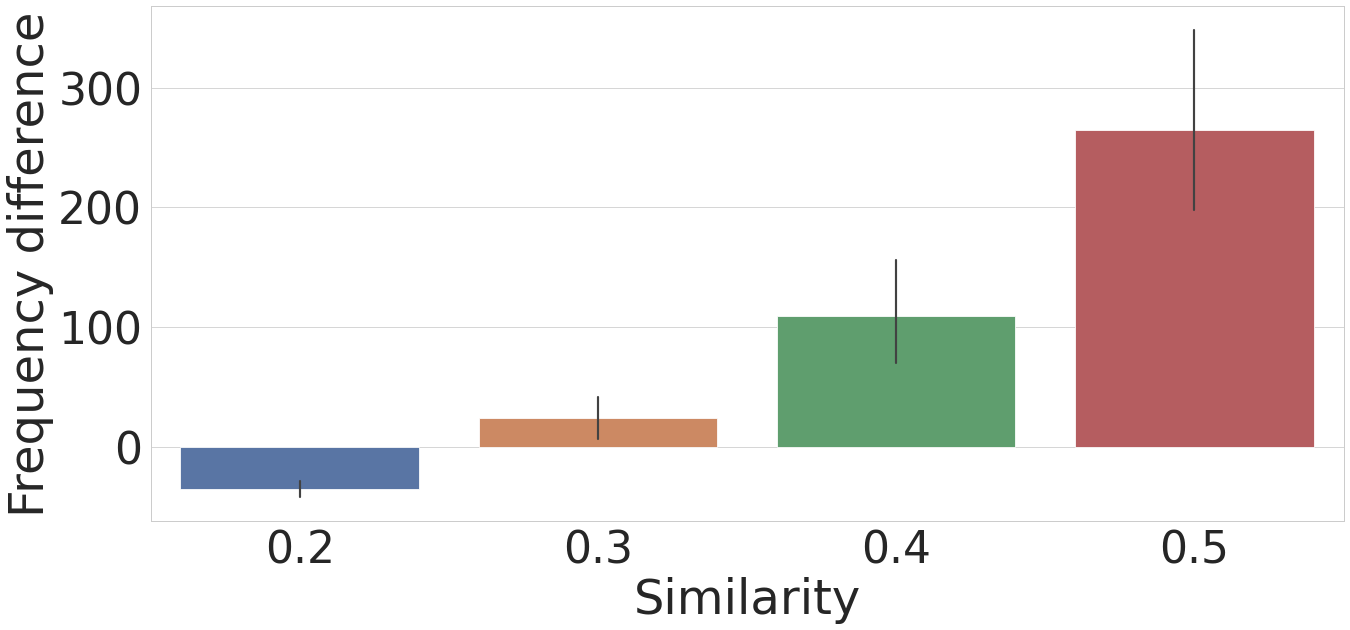

In [8]:
import pickle
import collections

ds = "lastfm"
k = 8
L = 300
w = 3700
method = "onebitminhash"

fn = f"python/results/{ds}/uniform/{method}/k_{k}_L_{L}.pickle"
gn = f"python/results/{ds}/opt/{method}/k_{k}_L_{L}.pickle"
with open(fn, 'rb') as f:
    res = pickle.load(f)

with open(gn, 'rb') as g:
    res2 = pickle.load(g)

query = 8

interesting_queries = [query] # analysis below shows that this is an interesting query

uniform_point = {}
opt_point = {}
diff = {}

for q in interesting_queries:
    points = res["res"][q]
    uniform_point[q] = collections.Counter(points)
    opt_point[q] = collections.Counter(res2["res"][q])

for q in interesting_queries:
    for p, cnt in uniform_point[q].items():
        diff.setdefault(q, {})
        diff[q][p] = cnt - opt_point[q][p]


diff = diff[q]

diff_with_sim = {}

data, queries, _, _ = get_dataset("lastfm")

for p, c in diff.items():
    diff_with_sim[p] = (c, jaccard(data[p], queries[q]))

# average with standard
s = 0
for p, cnt in uniform_point[q].items():
    jj = jaccard(data[p], queries[q])  
    s += cnt * jj
print(f"avg. sim (biased): {s / len(res['res'][q])}")

# average with opt
s = 0
for p, cnt in opt_point[q].items():
    s += cnt * jaccard(data[p], queries[q])
print(f"avg. sim (debiased): {s / len(res['res'][q])}")

df_dict = {
    "freq": [],
    "sim": []
}


for p, (cnt, sim) in diff_with_sim.items():
        df_dict["freq"].append(cnt) 
        df_dict["sim"].append(float("%.1f" % sim))
df = pd.DataFrame(data=df_dict)
sns.barplot(data=df.rename(columns={"freq" : "Frequency difference", "sim" : "Similarity"}), x='Similarity', y='Frequency difference')
plt.tight_layout()
plt.savefig("plots/sampling_differences_lastfm.pdf")





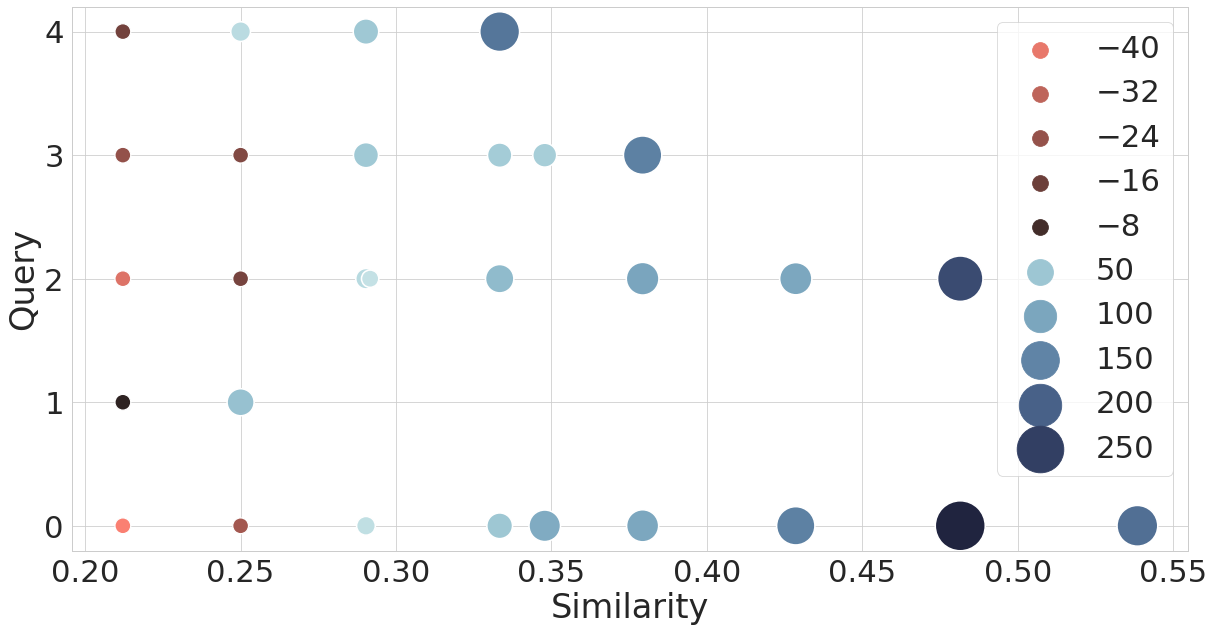

In [11]:
import pickle
import collections

ds = "lastfm"
k = 8
L = 300
w = 3700
method = "onebitminhash"

fn = f"python/results/{ds}/uniform/{method}/k_{k}_L_{L}.pickle"
gn = f"python/results/{ds}/opt/{method}/k_{k}_L_{L}.pickle"
with open(fn, 'rb') as f:
    res = pickle.load(f)

with open(gn, 'rb') as g:
    res2 = pickle.load(g)
interesting_queries = get_interesting_queries(res)

uniform_point = {}
opt_point = {}
diff = {}

for q in interesting_queries:
    points = res["res"][q]
    uniform_point[q] = collections.Counter(points)
    opt_point[q] = collections.Counter(res2["res"][q])

for q in interesting_queries:
    for p, cnt in uniform_point[q].items():
        #print(q, p, cnt)
        diff.setdefault(q, {})
        diff[q][p] = cnt - opt_point[q][p]


produce_distribution_plot(diff, res["dataset"], distance_f=jaccard, r=0.2)

#produce_distribution_plot(fn, distance_f=jaccard, r=0.2, interesting_queries=interesting_queries)
#plt.show()
#produce_distribution_plot(gn, distance_f=jaccard, r=0.2, interesting_queries=interesting_queries)

# Discussion: Approximate neighborhood is unfair?

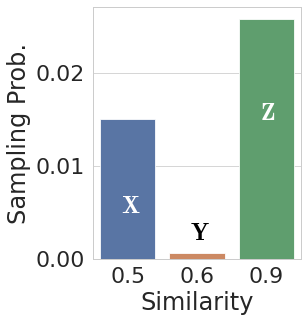

In [15]:
# Just run the experiment in here
import os

if not os.path.isfile("exp-res/approx.csv"):
    import approx_exp
    approx_exp.run("exp-res/approx.csv")

plt.rcParams["figure.figsize"] =(5,5)
sns.set_context('paper', font_scale=2.5)

df = pd.read_csv("exp-res/approx.csv")
df['sim'] = [0.9, 0.6, 0.5]
df['prob'] = df[['count', 'runs']].apply(lambda x: x[0] / x[1], axis=1)

ax = sns.barplot(data=df.rename(columns={'sim': 'Similarity', 'prob' : 'Sampling Prob.'}), x='Similarity', y='Sampling Prob.')
ax.text(-0.1, 0.005, "$\mathbf{X}$", horizontalalignment='left', size='medium', color='white', weight='semibold')
ax.text(1.9, 0.015, "$\mathbf{Z}$", horizontalalignment='left', size='medium', color='white', weight='semibold')
ax.text(0.9, 0.002, "$\mathbf{Y}$", horizontalalignment='left', size='medium', color='black', weight='semibold')
plt.tight_layout()
plt.savefig("plots/sampling_prob.pdf")




# Running time experiments

In [16]:
import glob
df = pd.DataFrame(columns=["dataset", "method", "tvd", "time"])

plt.rcParams["figure.figsize"] =(30,10)
sns.set_context('paper', font_scale=2.5)

for csv in glob.glob("exp-res/*.out"):
    tmp_df = pd.read_csv(csv, names=["method", "tvd", "time"])
    tmp_df['dataset'] = csv.split("/")[-1].split("_")[0]
    df = df.append(tmp_df).replace({
        0 : "uniform",
        1 : "weighted uniform",
        2 : "exact degree",
        3 : "approx. degree",
        4 : "rank",
        "glove-100-angular-data" : "GLOVE",
        "sift-128-euclidean-data" : "SIFT", 
        "mnist-784-euclidean-data" : "MNIST"
    })

df

,dataset,method,tvd,time
0,GLOVE,uniform,0.354862,0.004845
1,GLOVE,weighted uniform,0.194162,0.005410
2,GLOVE,exact degree,0.036494,0.048426
3,GLOVE,approx. degree,0.087132,0.042093
4,GLOVE,rank,0.036696,0.051601
0,MNIST,uniform,0.338809,0.009598
1,MNIST,weighted uniform,0.251545,0.010397
2,MNIST,exact degree,0.037641,0.109185
3,MNIST,approx. degree,0.083952,0.072515
4,MNIST,rank,0.037811,0.083315


<Figure size 2160x720 with 0 Axes>

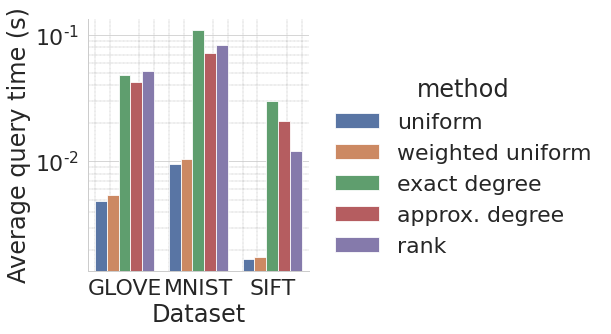

In [17]:
plt.clf()
g = sns.catplot(data=df[['method', 'time', 'dataset']], x="dataset", y="time", hue="method", kind="bar")
g.set_axis_labels("Dataset", "Average query time (s)")
plt.yscale('log')
g.ax.minorticks_on()
g.ax.grid(which='minor', linestyle=':', linewidth=0.3, color='black')
g.tight_layout()
plt.savefig('plots/running_time.pdf')